# **Tutorial 1:Task definition, application, relations and impacts on generalization**

**Week 1, Day 2: Comparing Tasks**

**By Neuromatch Academy**

__Content creators:__ Deying Song, Leila Wehbe 

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]


___


# Tutorial Objectives

*Estimated timing of tutorial: 90 minutes*

This tutorial will introduce you to generalization in the context of modern AI systems. We'll look at a particular system trained for handwriting recognition–TrOCR. We'll review what makes that model tick–the transformer architecture–and explore what goes on into training and finetuning large-scale models. We'll look at how augmentations can bake in particular inductive biases in transformers. Finally, we'll have a bonus section on scaling laws.

Our learning objectives for today are:

1.   Specify down different tasks in terms of cost functions
2.   Train a network to achieve these tasks and compare these networks
3.   Specify different notions of generalization, especially:
  *   o.o.d. testing
  *   sample complexity
  *   iteration complexity (ie number of data touches, even if it’s repeated touches on a fixed data set)
  *   representation generalization

**Important note**: this tutorial leverages GPU acceleration. Using a GPU runtime in colab will make the the tutorial run 10x faster.

Let's get started!


---
# Setup



In [ ]:
# @title Install dependencies

!pip install torch torchvision -U torchmetrics
!pip install numpy matplotlib torch torchvision tqdm ipysankeywidget ipywidgets

In [ ]:
# @title Import dependencies

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from tqdm.notebook import tqdm
import time
from pathlib import Path
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
import logging

In [ ]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting functions

In [ ]:
# @title Helper functions

class BottleneckLayer(nn.Module):

    def __init__(self, M):
        super(BottleneckLayer, self).__init__()
        self.fc = nn.Linear(10, M)

    def forward(self, x):
        x = F.relu(self.fc(x))
        return x
        
class ConvNeuralNetDecoder(nn.Module):

    def __init__(self, M):
        super(ConvNeuralNetDecoder, self).__init__()
        self.fc3 = nn.Linear(M, 84)
        self.fc2 = nn.Linear(84, 120)
        self.fc1 = nn.Linear(120, 16 * 5 * 5)

        self.convT2 = nn.ConvTranspose2d(16, 6, 5, stride=2, padding=0, output_padding=1)
        self.convT1 = nn.ConvTranspose2d(6, 1, 5, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc1(x))

        x = x.view(-1, 16, 5, 5)

        x = F.relu(self.convT2(x))
        x = F.relu(self.convT1(x))

        return x
        
def save_model(model, task_name, N_train_data):

    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    MODEL_NAME = "ConvNet_" + task_name + "_" + str(N_train_data) + ".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    print(f"Saving the model: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

"""
# Loading the saved model
model_lenet5_v1_mnist_loaded = LeNet5V1()
model_lenet5_v1_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
"""

def get_random_sample_dataloader(dataset, batch_size, M):
    indices = torch.randperm(len(dataset))[:M]
    sampler = torch.utils.data.SubsetRandomSampler(indices)
    sampled_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    return sampled_loader

def get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data):

    sampled_train_loader = get_random_sample_dataloader(train_dataset, batch_size, N_train_data)

    N_val_data = int(N_train_data / 9.0)
    if N_val_data < 30:
        N_val_data = int(30)
    sampled_val_loader = get_random_sample_dataloader(val_dataset, batch_size, N_val_data)

    return sampled_train_loader, sampled_val_loader
    
def create_sankey_links(X, y, output):
    """
    Creates links for a Sankey diagram based on true and predicted labels.

    Parameters:
    - X: Input data.
    - y: True labels for the input data.
    - output: Predicted labels for the input data.

    Returns:
    - A list of dictionaries, each representing a link for the Sankey diagram.
    """
    # Initialize a dictionary to store link data with (source, target) as keys
    link_data = {}

    # Iterate through each data point
    for true_label, predicted_label in zip(y, output):
        # Define the key as a tuple of (true_label, predicted_label)
        key = (true_label, predicted_label)

        # Increment the value for this link, or set to 1 if it's the first occurrence
        if key in link_data:
            link_data[key] += 1
        else:
            link_data[key] = 1

    # Convert the link data into the list format expected by Sankey diagram functions
    links = [{"source": source, "target": target, "value": value}
              for (source, target), value in link_data.items()]

    return links

class Accuracy:
    def __init__(self, task='multiclass', num_classes=10):
        assert task == 'multiclass', "Only supports `multiclass` task accuracy!"
        self.num_classes = num_classes

    def __call__(self, predicted, target):
        correct = predicted.eq(target.view_as(predicted)).sum().item()
        return correct / predicted.size(0)

def train(model, train_dataloader, val_dataloader, test_dataloader, cost_fn, optimizer, epochs_max, acc_flag, triplet_flag):

    tstart = time.time()

    accuracy = Accuracy(task='multiclass', num_classes=10)

    epoch = 0
    val_cost_last = 100000.0
    val_cost_current = 100000.0

    if triplet_flag: # with triplet loss

        while epoch < epochs_max and val_cost_current <= val_cost_last:
            epoch += 1

            # Training loop
            train_cost = 0.0
            for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(train_dataloader):
                model.train()
                anchor_reconstruct = model(anchor_img)
                positive_reconstruct = model(positive_img)
                negative_reconstruct = model(negative_img)
                cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                train_cost += cost.item()
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)

            # Validation loop
            val_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(val_dataloader):
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    val_cost += cost.item()
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost

            # Test loop
            test_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(test_dataloader):
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    test_cost += cost.item()
                test_cost /= len(test_dataloader)

            print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                  f"Val cost: {val_cost: .5f}| " +
                  f"Test cost: {test_cost: .5f}|")
            #print(1)

    else: # with loss functions taking two arguments as inputs

        while epoch < epochs_max and val_cost_current <= val_cost_last:
            epoch += 1

            # Training loop
            train_cost, train_acc = 0.0, 0.0
            for batch_idx, (X, y) in enumerate(train_dataloader):
                #print(y.size())
                model.train()
                predictions = model(X)
                cost = cost_fn(predictions, y)
                train_cost += cost.item()
                if acc_flag:
                    _, predicted_classes = torch.max(predictions, 1)
                    acc = accuracy(predicted_classes, y)
                    train_acc += acc
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            if acc_flag:
                train_acc /= len(train_dataloader)

            # Validation loop
            val_cost, val_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(val_dataloader):
                    predictions = model(X)
                    #print(X.size())
                    #print(y.size())
                    cost = cost_fn(predictions, y)
                    val_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        val_acc += acc
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                if acc_flag:
                    val_acc /= len(val_dataloader)

            # Test loop
            test_cost, test_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(test_dataloader):
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    test_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        test_acc += acc
                test_cost /= len(test_dataloader)
                if acc_flag:
                    test_acc /= len(test_dataloader)

            if acc_flag:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| Train acc: {train_acc: .5f}| " +
                      f"Val cost: {val_cost: .5f}| Val acc: {val_acc: .5f}| " +
                      f"Test cost: {test_cost: .5f}| Test acc: {test_acc: .5f}")
            else:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                      f"Val cost: {val_cost: .5f}| " +
                      f"Test cost: {test_cost: .5f}|")

    elapsed = time.time() - tstart
    print('Elapsed: %s' %elapsed)

def create_sankey_links_autoencoder(X, reconstructed):
    link_data = {}
    N_datapoint = np.size(X, 0)
    N_pixel = np.size(X, 1)

    for id1 in range(N_pixel):
        link_data[("pixel "+str(id1)+" on", str(id1)+" on")] = 0
    for id1 in range(N_pixel):
        link_data[("pixel "+str(id1)+" on", str(id1)+" off")] = 0
    for id1 in range(N_pixel):
        link_data[("pixel "+str(id1)+" off", str(id1)+" on")] = 0
    for id1 in range(N_pixel):
        link_data[("pixel "+str(id1)+" off", str(id1)+" off")] = 0

    for n in range(N_datapoint):
        for pixel_id, (original_pixel, reconstructed_pixel) in enumerate(zip(X[n,:], reconstructed[n,:])):

            #print(original_pixel)

            if original_pixel>0.5:
                left_01 = "pixel "+str(pixel_id)+" on"
            else:
                left_01 = "pixel "+str(pixel_id)+" off"

            if reconstructed_pixel>0.5:
                right_01 = str(pixel_id)+" on"
            else:
                right_01 = str(pixel_id)+" off"

            key = (left_01, right_01)

            link_data[key] += 1


    links = [{"source": source, "target": target, "value": value}
              for (source, target), value in link_data.items()]
    return links

## **Part 1: formalize different tasks as cost functions and train the same architecture to achieve these tasks**

**network architecture**: a simple CNN (convolutional neural network) architecture

**dataset**: a part of the MNIST dataset, which has pictures of handwritten digits

In this tutorial, we will use the same base architecture and the same training datasets to achieve different tasks by creating different output layers and training them with different objective functions.

A **Convolutional Neural Network (CNN)** is a deep learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and differentiate one from the other.

Unlike (pure) feedforward neural networks, which flatten the input into a one-dimensional array, CNNs **preserve the spatial hierarchy of the input images**, making them particularly well-suited for processing data with a grid-like topology, such as images. A CNN architecture is designed to automatically and adaptively learn spatial hierarchies of features from low-level to high-level patterns.

The core building blocks of CNNs are convolutional layers, pooling layers, and fully connected layers. A schematic of CNN is shown below.

- **Convolutional layers** apply a convolution operation to the input, passing the result to the next layer. This allows the network to be deep with fewer parameters, enhancing the learning of feature hierarchies.
- **Pooling layers** reduce the dimensions of the data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer.
- **Fully connected layers** connect every neuron in one layer to every neuron in the next layer, and are typically used at the end of the network to make class predictions.

Due to their remarkable ability to ***capture the spatial and temporal dependencies in an image*** through the application of relevant filters, CNNs are extensively used in image and video recognition, recommender systems, image classification, medical image analysis, and natural language processing.

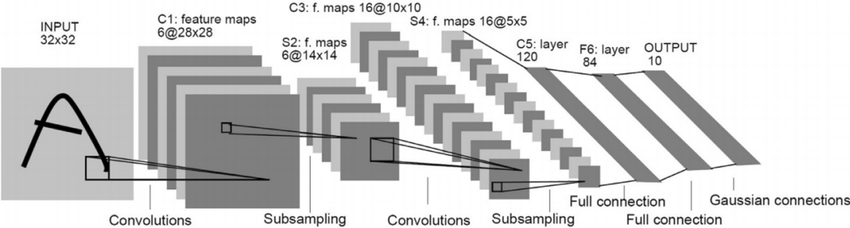

In [ ]:
# # Third-party Jupyter widgets
# # Support for third party widgets (widgets outside of the ipywidgets package) needs to be enabled separately.
# # Support for these widgets will be loaded from a CDN external from Colab.
#from google.colab import output
#output.enable_custom_widget_manager()

# # Support for third party widgets will remain active for the duration of the session. To disable support:
# from google.colab import output
# output.disable_custom_widget_manager()

In [ ]:
class ConvNeuralNet(nn.Module):

    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


**Preparing the data**

In [ ]:
#Loading the dataset and preprocessing

mnist_transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

train_val_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = mnist_transform,
                                           download = True)

test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = mnist_transform,
                                          download=True)

train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])


test_size_original = int(0.5 * len(test_dataset))
test_size_transfer = len(test_dataset) - test_size_original
test_dataset_original, test_dataset_transfer = torch.utils.data.random_split(dataset=test_dataset, lengths=[test_size_original, test_size_transfer])


train_dataset

len(train_dataset), len(val_dataset), len(test_dataset_original), len(test_dataset_transfer)

Visualizing some samples from the dataset.

In [ ]:
class_names = train_dataset.dataset.classes

torch.manual_seed(42)

fig = plt.figure(figsize=(8, 4))
rows, cols = 2, 5

mean = 0.1307
std = 0.3081

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    img_tensor = img * std + mean
    img_tensor = img_tensor / 2 + 0.5
    img_np = np.squeeze(img_tensor.numpy())
    fig.add_subplot(rows, cols, i)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()


Prepare the dataset for loading to the network

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader_original = torch.utils.data.DataLoader(dataset = test_dataset_original,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader_transfer = torch.utils.data.DataLoader(dataset = test_dataset_transfer,
                                           batch_size = batch_size,
                                           shuffle = True)

We provide the funtion to train the network.

For some of the tasks below, we will ***(optionally) interpret the learned representaions***. We will use the pathfinder method to contrust Sankey diagrams for each of the networks.

In [ ]:
epochs_max = 30
batch_size = 32

### **Task 1: Classification**

**Given the image of a hand-written digit, the task is to determine what digit it is.**



**Cost-function**: consider adding an output layer Y to the network structure which has 10 nodes, one for each digit.

-	If the outputs are one-hot, and you use a 0/1 loss, what would the problem be?
-	You decide that it’s better to have probability outputs that encode your certainty about each digit. What type of output layer can you use for this goal? You also decide to use binary-cross entropy. Write down the cost function. What advantage does it have?

In [ ]:
def cost_classification(output, target):
    
    ############################################################
    # Fill in this code to calculate character error rate and word error rate.
    # Hint: have a look at the torchmetrics documentation for the proper
    # metrics.
    #
    raise NotImplementedError("Student has to fill in these lines")
    ############################################################
    
    criterion = nn.BCELoss()
    target = target.to(torch.int64)
    batch_size = ...
    # Create a tensor of zeros with shape (batch_size, num_classes)
    target_one_hot = torch.zeros((batch_size, 10), device=target.device)
    # Use scatter_ to place '1's in the correct indices
    target_one_hot.scatter_(1, target.unsqueeze(1), 1)
    cost = ...
    return cost

In [ ]:
# to remove solution

def cost_classification(output, target):
    criterion = nn.BCELoss()
    target = target.to(torch.int64)
    batch_size = target.shape[0]
    # Create a tensor of zeros with shape (batch_size, num_classes)
    target_one_hot = torch.zeros((batch_size, 10), device=target.device)
    # Use scatter_ to place '1's in the correct indices
    target_one_hot.scatter_(1, target.unsqueeze(1), 1)
    cost = criterion(output, target_one_hot)
    return cost

**Implementation/training**: Add an output layer and write down the cost function in code.

-	Train separate networks on X, 10X, 100X, 1000X datapoints. Keep training until validation performance reduces. Save test performance during training for each epoch (but don’t use it for deciding when to stop training). Save each network.


In [ ]:
class ClassificationOutputLayer(nn.Module):

    def __init__(self):
        super(ClassificationOutputLayer, self).__init__()
        self.fc = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))

        return x

In [ ]:
class ClassificationConvNet(nn.Module):

    def __init__(self, ConvNet, Output):
        super(ClassificationConvNet, self).__init__()
        self.ConvNet = ConvNet
        self.Output = Output

    def forward(self, x):
        conv_intermediate = self.ConvNet(x)
        output = self.Output(conv_intermediate)

        return output

In [ ]:
N_data = 10
N_folds = np.array([1, 10, 100, 1000])
task_name = "classification"
acc_flag = True
triplet_flag = False
epochs_max = 30

for n in N_folds:
    model = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

    N_train_data = N_data * n
    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train(model, sampled_train_loader, sampled_val_loader, test_loader_original, cost_classification, optimizer, epochs_max, acc_flag, triplet_flag)

    save_model(model, task_name, N_train_data)

## Discussion point 1

Now that you have trained your network with different sample sizes, plot the generalization performance to the test dataset for each network across epochs. How can you describe the interaction of sample size and iteration complexity?

# Discussion point 2

In order to  interpret the representations learned by the models, use the pathfinder method to construct Sankey diagrams for each of the networks above. How do they compare?

In [ ]:
N_data = 10
N_folds = np.array([1, 10, 100, 1000])

test_loader_demo = torch.utils.data.DataLoader(dataset = test_dataset_original,
                                                   batch_size = len(test_dataset_original),
                                                   shuffle = True)
X, y = next(iter(test_loader_demo))

number_to_word = {
    0: 'zero', 1: 'one', 2: 'two', 3: 'three',
    4: 'four', 5: 'five', 6: 'six', 7: 'seven',
    8: 'eight', 9: 'nine'
}
converted_y = [f"{num.item()} - {number_to_word[num.item()]}" for num in y]


for n in N_folds:
    N_train_data = N_data * n
    MODEL_NAME = "./models/ConvNet_classification_" + str(N_train_data) + ".pth"
    model = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())
    model.load_state_dict(torch.load(MODEL_NAME))
    model.eval()
    output = model(X)
    _, output = torch.max(output, 1)
    links = create_sankey_links(X, converted_y, output.tolist())
    #sankey_temp = SankeyWidget(links=links)
    #display(sankey_temp)

    layout = Layout(width="200", height="240")
    sankey_temp = SankeyWidget(links=links)
    display(sankey_temp)

### **Task 2: Regression**

We have seen how to use the network architecture to acheive digit classification. We now explore another task using that same architecture. Namely, we focus on a regression task.

**Given the image of a hand-written digit, the task is to determine how many pixels are 'ON' (ON = value of pixel is greater than 0.5).**

*Note: This is a rather simple task that can be solved by adding all the pixels. We want to see how fat the CNN network from before can learn it.*

**Cost-function**: The training set you are given is the same numbers as before, with as training labels, the number of “ON” pixels in each. The output layer y now has only one node, predicting the number of white pixels.

- What should the cost function be?

- Do you expect that this network will have exact answers?


In [ ]:
def cost_regression(output, target):
    ############################################################
    raise NotImplementedError("Student exercise")
    ############################################################
    criterion = ...
    cost = ...
    return cost

In [ ]:
# to remove solution

def cost_regression(output, target):
    criterion = nn.MSELoss()
    cost = criterion(output, target)
    return cost

**Implementation/training**: Add an output layer and write down the cost function in code.

-	Train separate networks on X, 10X, 100X, 1000X datapoints. Keep training until validation performance reduces. Save test performance during training for each epoch (but don’t use it for deciding when to stop training). Save each network.


In [ ]:
class RegressionOutputLayer(nn.Module):

    def __init__(self):
        super(RegressionOutputLayer, self).__init__()
        self.fc = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        #x_int = x.int()
        #x = x_int.float()

        return x

In [ ]:
class RegressionConvNet(nn.Module):

    def __init__(self, ConvNet, Output):
        super(RegressionConvNet, self).__init__()
        self.ConvNet = ConvNet
        self.Output = Output

    def forward(self, x):
        conv_intermediate = self.ConvNet(x)
        output = self.Output(conv_intermediate)

        return output

In [ ]:
class RegressionMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset.dataset
        # self.transform to be confirmed
        self.transform = transforms.Compose([transforms.Resize((32,32)),
                                             transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

        self.labels = np.array(mnist_dataset.dataset.targets)
        self.data = mnist_dataset.dataset.data
        self.labels_set = set(self.labels)
        self.label_to_indices = {label: np.where(self.labels == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):

        X = self.data[index]
        if len(X.shape) == 2:
            X = X.unsqueeze(0)
        X = self.transform(X.to(torch.float))
        updated_label = torch.sum((X > 0.5),(1,2)).float()
        return X, updated_label

    def __len__(self):
        return len(self.mnist_dataset)


In [ ]:
N_data = 10
N_folds = np.array([1, 10, 100, 1000])
task_name = "regression"
acc_flag = False
triplet_flag = False

train_dataset_regression = RegressionMNIST(train_dataset)
val_dataset_regression = RegressionMNIST(val_dataset)
test_dataset_original_regression = RegressionMNIST(test_dataset_original)
test_loader_original_regression = torch.utils.data.DataLoader(dataset = test_dataset_original_regression,
                                           batch_size = batch_size,
                                           shuffle = True)

for n in N_folds:
    #print(n)
    model = RegressionConvNet(ConvNeuralNet(), RegressionOutputLayer())

    N_train_data = N_data * n
    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset_regression, val_dataset_regression, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train(model, sampled_train_loader, sampled_val_loader, test_loader_original_regression, cost_regression, optimizer, epochs_max, acc_flag, triplet_flag)

    save_model(model, task_name, N_train_data)

# Discussion point 3

-	Plot the generalization performance to the test dataset for each network across epochs. How can you describe the interaction of sample size and iteration complexity?
- How do these compare with the classification example above?

### **Task 3: Auto-encoder**

Now, we use the same architecture for unsupervised learning.

**Given the image of a hand-written digit, the task is to compress it down to a small dimensional representation (of size M), such that it can be reconstructed with minimal error.**

For this purpose you need to build an autoencoder which can reconstruct the original image in its original size.

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, encoder, bottleneck, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.bottleneck = bottleneck
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        bottlenecked = self.bottleneck(encoded)
        decoded = self.decoder(bottlenecked)
        return decoded

**Cost-function**: What cost function will be most appropriate for the reconstruction task with an autoencoder?

In [ ]:
def cost_autoencoder(output, target):
    ###########################################################
    raise NotImplementedError("Student exercise")
    ############################################################
    criterion = nn.MSELoss()
    output_flat = ...
    target_flat = ...
    cost = criterion(output_flat, target_flat)
    return cost

In [ ]:
# to remove solution

def cost_autoencoder(output, target):
    criterion = nn.MSELoss()
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    cost = criterion(output_flat, target_flat)
    return cost

**Implementation/training**: Add a bottleneck layer of size M and then multiple layers to reconstruct the image. Write down the cost function in code.
-	Train separate networks on X, 10X, 100X, 1000X datapoints. Keep training until validation performance reduces. Save test performance during training for each epoch (but don’t use it for deciding when to stop training). Save each network.


In [ ]:
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset.dataset
        # self.transform to be confirmed
        self.transform = transforms.Compose([transforms.Resize((32,32)),
                                             transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

        self.labels = np.array(mnist_dataset.dataset.targets)
        self.data = mnist_dataset.dataset.data
        self.labels_set = set(self.labels)
        self.label_to_indices = {label: np.where(self.labels == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):

        X = self.data[index]
        if len(X.shape) == 2:
            X = X.unsqueeze(0)
        X = self.transform(X.to(torch.float))
        reconstruct = X
        return X, reconstruct

    def __len__(self):
        return len(self.mnist_dataset)


In [ ]:
N_data = 10
N_folds = np.array([1, 10, 100, 1000])
task_name = "autoencoder"
M = 5
acc_flag = False
triplet_flag = False

train_dataset_autoencoder = AutoencoderMNIST(train_dataset)
val_dataset_autoencoder = AutoencoderMNIST(val_dataset)
test_dataset_original_autoencoder = AutoencoderMNIST(test_dataset_original)
test_loader_original_autoencoder = torch.utils.data.DataLoader(dataset = test_dataset_original_autoencoder,
                                           batch_size = batch_size,
                                           shuffle = True)

for n in N_folds:
    model = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

    N_train_data = N_data * n
    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset_autoencoder, val_dataset_autoencoder, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train(model, sampled_train_loader, sampled_val_loader, test_loader_original_autoencoder, cost_autoencoder, optimizer, epochs_max, acc_flag, triplet_flag)

    save_model(model, task_name, N_train_data)

# Discussion point 4

-	Plot the generalization performance to the test dataset for each network across epochs. How can you describe the interaction of sample size and iteration complexity?
- How do these compare with the classification and regression examples above?

# Discussion point 5

Use the pathfinder method to construct Sankey diagrams for each of the auto-encoders. Do you find the same patterns as for the classification task?

In [ ]:
N_data = 10
N_folds = np.array([1, 10, 100, 1000])

test_loader_demo = torch.utils.data.DataLoader(dataset = test_dataset_original,
                                                   batch_size = len(test_dataset_original),
                                                   shuffle = True)
X, y = next(iter(test_loader_demo))

img_tensor = X * std + mean
img_tensor = img_tensor / 2 + 0.5
img_np = np.squeeze(img_tensor.numpy())
img_np = np.reshape((img_np>0.5).astype(int), (np.size(img_np, 0), -1))


for n in np.array([1]):
    N_train_data = N_data * n
    MODEL_NAME = "./models/ConvNet_autoencoder_" + str(N_train_data) + ".pth"
    model = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))
    model.load_state_dict(torch.load(MODEL_NAME))
    model.eval()

    output = model(X)
    #print(output.size())
    img_tensor = output * std + mean
    img_tensor = img_tensor / 2 + 0.5
    img_np_output = np.squeeze(img_tensor.detach().numpy())
    img_np_output = np.reshape((img_np_output>0.5).astype(int), (np.size(img_np_output, 0), -1))


    links = create_sankey_links_autoencoder(img_np, img_np_output)
    #sankey_temp = SankeyWidget(links=links)
    #display(sankey_temp)

    layout = Layout(width="200", height="240")
    sankey_temp = SankeyWidget(links=links)
    display(sankey_temp)

### **Task 4: Self-supervised: inpainting**

Now, we try a final, self-supervised task with the same architecture.

**Given the image of a hand-written digit with an NxN sized obstruction (each time in a different place), the task is to complete the image by providing the entire image with the obstructed part of the drawing as accurately as possible.**

Note: Because we use MNIST, this task is significantly easier than it would be for natural images. Also, we implement a simplified example of inpainting.

In [ ]:
def add_random_obstruction(images, obstruction_size=8):
    """
    Adds a random N x N obstruction to a batch of images.

    Parameters:
    - images: A batch of images as a PyTorch tensor, shape (batch_size, channels, height, width)
    - obstruction_size: Size of the square obstruction (N)

    Returns:
    - A new batch of images with the obstruction added.
    """
    # Clone the images to avoid modifying the original data
    obstructed_images = images.clone()

    batch_size, height, width = images.size()

    for i in range(batch_size):
        # Choose a random location for the obstruction
        y = np.random.randint(0, height - obstruction_size)
        x = np.random.randint(0, width - obstruction_size)

        # Apply the obstruction by setting the pixel values to 0 (or another value)
        obstructed_images[i, y:y+obstruction_size, x:x+obstruction_size] = 0

    return obstructed_images

**Cost-function**: What cost function will be most appropriate for the inpainting task?

In [ ]:
def cost_inpainting(output, target):
    criterion = nn.MSELoss()
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    cost = criterion(output_flat, target_flat)
    return cost

**Implementation/training**: Add a bottleneck layer of size M and then multiple layers to reconstruct the image. Can we use the same architecture as the previous question? Write down the cost function in code.
-	Train separate networks on X, 10X, 100X, 1000X datapoints. Keep training until validation performance reduces. Save test performance during training for each epoch (but don’t use it for deciding when to stop training). Save each network.


In [ ]:
class InpaintingMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset.dataset
        # self.transform to be confirmed
        self.transform = transforms.Compose([transforms.Resize((32,32)),
                                             transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

        self.labels = np.array(mnist_dataset.dataset.targets)
        self.data = mnist_dataset.dataset.data
        self.labels_set = set(self.labels)
        self.label_to_indices = {label: np.where(self.labels == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):

        X = self.data[index]
        if len(X.shape) == 2:
            X = X.unsqueeze(0)
        X = self.transform(X.to(torch.float))
        reconstruct = X
        obstructed = add_random_obstruction(X, obstruction_size=8)
        return obstructed, reconstruct

    def __len__(self):
        return len(self.mnist_dataset)

In [ ]:
N_data = 10
N_folds = np.array([1, 10, 100, 1000])
task_name = "inpainting"
acc_flag = False
triplet_flag = False

train_dataset_inpainting = InpaintingMNIST(train_dataset)
val_dataset_inpainting = InpaintingMNIST(val_dataset)
test_dataset_original_inpainting = InpaintingMNIST(test_dataset_original)
test_loader_original_inpainting = torch.utils.data.DataLoader(dataset = test_dataset_original_inpainting,
                                           batch_size = batch_size,
                                           shuffle = True)

for n in N_folds:
    model = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

    N_train_data = N_data * n
    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset_inpainting, val_dataset_inpainting, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    train(model, sampled_train_loader, sampled_val_loader, test_loader_original_inpainting, cost_inpainting, optimizer, epochs_max, acc_flag, triplet_flag)

    save_model(model, task_name, N_train_data)

# Discussion point 6

-	Plot the generalization performance to the test dataset for each network across epochs. How can you describe the interaction of sample size and iteration complexity?
- How do these compare with the other example above?


## **Part 2: Generalization (ood and generalization of representations)**

In the first part of this tutorial, we focused on the ability to generalize to specific tasks in terms of sample and iteration complexity. Here, we focus on generalization of representations across tasks.

**Taskonomy**: A biological agent uses parts of their brain (e.g., the visual system) to perform a wide variety of tasks. The representations that this system has need to be general enough to perform different tasks, but at the same time, the representations in specific areas, or under different requirements, can be different. **We evaluate the ability of the representations we learn above to perform different tasks.**

### **Part 2-1: Transfer**

For this question, use for each task the network with the best test performance out of the ones you have saved. A new test set will be provided for each task.

To test generalization from one model to the other, you need to ***create a new network for the destination task*** (using the same architecture for that task as part 1), then ***copy the weights for the first N layers from the source network, and fix these weights***. You then ***train the rest of the layers on the destination network***.

Now you can compare the new performance to the original performance. Ideally, we want you to learn the transfer performance between each pair of networks. But due to time constraints, we provide you with our numbers at the end of this section. For now, try the following transfers:

In [ ]:
def transfer_and_freeze_layers(source_model, destination_model, N):
    """
    Transfers the weights of the first N layers from the source model to the
    destination model and freezes them.

    Parameters:
    - source_model: The model from which weights are copied.
    - destination_model: The model to which weights are copied and trained.
    - N: The number of layers to transfer and freeze.

    Note: This function assumes the first N layers are directly accessible and
    does not handle nested modules automatically.
    """

    # Ensure both models are in the same mode (train/eval).
    source_model.eval()
    destination_model.train()

    for layer_id, (param_src, param_dest) in enumerate(zip(source_model.parameters(), destination_model.parameters())):
        #print(layer_id)
        if layer_id < N:
            param_dest.data.copy_(param_src.data)
            param_dest.requires_grad = False

    """
    # Get the parameters of both models
    source_parameters = list(source_model.parameters())
    destination_parameters = list(destination_model.parameters())

    # Copy the weights from the source model to the destination model for the first N layers
    with torch.no_grad():
        for i in range(N):
            destination_parameters[i].data.copy_(source_parameters[i].data)

    # Freeze the first N layers of the destination model
    for name, param in destination_model.named_parameters():
        # This assumes layer naming allows us to identify the first N layers
        if int(name.split('.')[0]) < N:  # Adjust condition based on actual naming
            param.requires_grad = False

    """

**Classification => Autoencoder**

How well does this work? Would you have predicted it based on the Pathfinder method?

In [ ]:
def get_test_loss(model, cost_fn, test_dataloader):
    test_cost, test_acc = 0.0, 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(test_dataloader):
            predictions = model(X)
            cost = cost_fn(predictions, y)
            test_cost += cost.item()
        test_cost /= len(test_dataloader)
    print(test_cost)


In [ ]:
def get_test_accuracy(model, test_dataloader):
    test_acc = 0.0
    model.eval()
    accuracy = Accuracy(task='multiclass', num_classes=10)
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(test_dataloader):
            predictions = model(X)
            _, predicted_classes = torch.max(predictions, 1)
            acc = accuracy(predicted_classes, y)
            test_acc += acc
        test_acc /= len(test_dataloader)
    print(test_acc)

In [ ]:
MODEL_NAME_SOURCE = "./models/ConvNet_classification_10000.pth"
model_source = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())
model_source.load_state_dict(torch.load(MODEL_NAME_SOURCE))

M = 5
model_destination = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

N = 10
transfer_and_freeze_layers(model_source, model_destination, N)

N_train_data = 10000
acc_flag = False
triplet_flag = False
test_dataset_transfer_autoencoder = AutoencoderMNIST(test_dataset_transfer)
test_loader_transfer_autoencoder = torch.utils.data.DataLoader(dataset = test_dataset_transfer_autoencoder,
                                           batch_size = batch_size,
                                           shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset_autoencoder, val_dataset_autoencoder, batch_size, N_train_data)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
train(model_destination, sampled_train_loader, sampled_val_loader, test_loader_transfer_autoencoder, cost_autoencoder, optimizer, epochs_max, acc_flag, triplet_flag)

model_original = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))
MODEL_NAME_ORIGINAL = "./models/ConvNet_autoencoder_10000.pth"
model_original.load_state_dict(torch.load(MODEL_NAME_ORIGINAL))
get_test_loss(model_original, cost_autoencoder, test_loader_transfer_autoencoder)


Now try the following transfer:

**Autoencoder => Classification**

How well does this work? Would you have predicted it based on the Pathfinder method?

In [ ]:
MODEL_NAME_SOURCE = "./models/ConvNet_autoencoder_10000.pth"
M = 5
model_source = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))
model_source.load_state_dict(torch.load(MODEL_NAME_SOURCE))

model_destination = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

N = 10
transfer_and_freeze_layers(model_source, model_destination, N)

N_train_data = 10000
acc_flag = True
triplet_flag = False
test_loader_transfer = torch.utils.data.DataLoader(dataset = test_dataset_transfer,
                                           batch_size = batch_size,
                                           shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
train(model_destination, sampled_train_loader, sampled_val_loader, test_loader_transfer, cost_classification, optimizer, epochs_max, acc_flag, triplet_flag)

model_original = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())
MODEL_NAME_ORIGINAL = "./models/ConvNet_classification_10000.pth"
model_original.load_state_dict(torch.load(MODEL_NAME_ORIGINAL))
get_test_loss(model_original, cost_classification, test_loader_transfer)
get_test_accuracy(model_original, test_loader_transfer)


Finally, try this last transfer:

**Regression => Any other task**

What is your prediction?

# Appendix

### **Out of Distribution (OOD)**

Now, we look at transfer ***across distributions***. We have a new dataset, with the same labels, but you should trans. The classifier cannot predict for these new labels as it has not seen them before, however, we can still test if the representations learned at the different layers are any useful for the new task.

First, follow the transfer procedure above to ***copy the weights up to the first fully connected layer to a new network***, fix the weights, and train this new network ***(only top layers)*** on classifying MNIST letters.


Classification => Autoencoder

Autoencoder => Classification

Regression => Any other task

Now, try the transfer ***starting at earlier layers***, until you only use the first convolutional layer. Which setting yields the most accurate transfer? What do you conclude?